### 팔레트 추출 및 상품 매칭 통합 코드
    
    최초 작성일 : 20/04/04
    작성자 : 김은주
    
    작성내용 : 팔레트 추출 및 상품 매칭 통합 코드 (CAIProjectModule.py)
               
               personal_color_palette 모듈화 및 테스트
               -> ColorPalette클래스 (palette_bright / palette_harmony / matchedPrdt / to_rgb / show_color)
               -> DatabaseConnetion클래스(connectDB / select_prdt_color / getPrdtimage)
               
               Main_product_color_extraction 모듈화 및 테스트
               -> ColorClustering클래스 (greytone_filter / color_generator / colorClustering)
               -> DatabaseConnection클래스 (getUserPurchase)
               
               최종 리턴 필요 값 추출 코드 정리
               -> 팔레트 별 웹용 RGB 값
               -> 추천항목 별 웹용 이미지링크

    수정내용 
        20/04/06
               greytone_filter 개선
               -> 회색조 필터링 시 리턴값이 없으면 필터링 전 hsv 리턴
               colorClustering 오류 수정
               -> NearestCentroid() : 클러스터 수가 2개 미만일 때 중앙값을 찾을 수 없음
               -> 최소 클러스터 수 2개로 수정
               
        20/04/07
               matchedPrdt 개선
               -> 팔레트 별 중복되는 상품코드 발생 시 제외
               getUserPurchase 오류 수정
               -> 조회 닉네임의 구매목록이 없는 경우 오류 수정
               -> 해당 오류 발생 시 웹용 이미지링크 최종 리턴값
                   : 'error:No matched user or No matched purchase list'

In [1]:
import CAIProjectModule

CP = CAIProjectModule.ColorPalette()
CD = CAIProjectModule.DatabaseConnetion()
CC = CAIProjectModule.ColorClustering()

C:\Users\acorn\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.utils.testing module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.utils. Anything that cannot be imported from sklearn.utils is now part of the private API.
  warnings.warn(message, FutureWarning)
C:\Users\acorn\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.neighbors.nearest_centroid module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [6]:
### DB 연결
# database = {"host":"49.142.181.65", "user":"cai", "passwd":"1234", "db":"final"}
database = {"host":"192.168.0.41", "user":"cai", "passwd":"1234", "db":"final"}
# database = {"host":"localhost", "user":"root", "passwd":"1111", "db":"musinsa_test"}
cursor = CD.connectDB(database)

### PRDT_IMAGE 테이블에 H, S, V, 상품코드 조회
HSV = CD.select_prdt_color(cursor)

########################################### 컬러 팔레트 추출 #########################################
# 얼굴 측색결과 hsv 받아와야함
hsv = [27, 45, 80]
############################

### 얼굴 측색값 기준 팔레트 추출 : 각 6개 색 추출
hsv_palette_bright = CP.palette_bright(hsv)
hsv_palette_harmony = CP.palette_harmony(hsv)

### 웹용 팔레트 RGB 변환 : 각 6개 색
rgb_palette_bright = CP.to_rgb(hsv_palette_bright)
rgb_palette_harmony = CP.to_rgb(hsv_palette_harmony)


########################################### 주요 구매색 추출 #########################################
# 웹에서 받아와야함
# 테스트용 DB 닉네임 (구매 많은 순)
nicknames = ["ZENG", "맥클", "말쑥2", "오케이굿잡", "추붐", "쵸롱잉", "윤뽀돌잉", "때때로", "hyunOoa",
             "siun9", "빵도니", "휘파람위히히히"]
# user_nick = nicknames[0]
user_nick = "JAY"
############################

### 유저 닉네임에 따른 구매목록 조회
purchase_prdt = CD.getUserPurchase(cursor, user_nick)
### 회색조 필터링 (흰색/검은색 상품 필터링)
purchase_hsv = CC.greytoneFilter(purchase_prdt)
### Clustering 정확도를 위한 색값 제너레이팅
purchase_HSV = CC.colorGenerator(purchase_hsv)
### Clustering 중앙값(주구매색) 리턴
centroid = CC.colorClustering(purchase_HSV)
########################################### 상품매칭 & 이미지  #########################################

### 팔레트 컬러 상품 매칭 : 각 상품코드 6개
prdtCode_bright = CP.matchedPrdt(hsv_palette_bright, HSV)
prdtCode_harmony = CP.matchedPrdt(hsv_palette_harmony, HSV)
prdtCode_purchase = CP.matchedPrdt(centroid, HSV)

### 상품 이미지링크 갖고오기 : 웹페이지 노출용 이미지링크 각 6개
imgLink_bright = CD.getPrdtimage(cursor, prdtCode_bright)
imgLink_harmony = CD.getPrdtimage(cursor, prdtCode_harmony)
imgLink_purchase = CD.getPrdtimage(cursor, prdtCode_purchase)

C:\Users\acorn\Desktop\jay\pythonwork\CAI\CAIProjectModule.py:568: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if "No matched user" in HSV:
C:\Users\acorn\Desktop\jay\pythonwork\CAI\CAIProjectModule.py:377: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if "No matched user" in personal_palette:


In [ ]:
"""
24915

CREATE VIEW VW_USER_HSV
AS
SELECT b.H, b.S, b.V
	FROM PRDT_REVIEW a, PRDT_IMAGE b
	WHERE a.PRDT_CODE = b.PRDT_CODE
        AND b.H is NOT NULL
        AND a.PRDT_CODE in (SELECT PRDT_CODE FROM PRDT_IMAGE);

→ SELECT * FROM vw_test; 만 쳐서 계속 같은 값을 조회할 수 있음
"""

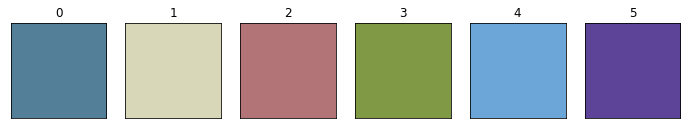

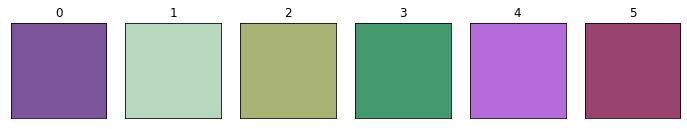

C:\Users\acorn\Desktop\jay\pythonwork\CAI\CAIProjectModule.py:352: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if "No matched user" in personal_palette:


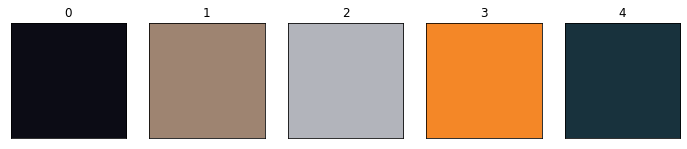

In [7]:
### 팔레트 색 확인
CP.show_colors(hsv_palette_bright)
CP.show_colors(hsv_palette_harmony)
CP.show_colors(centroid)

In [8]:
# 웹용 컬러팔레트 RGB값
print(hsv_palette_bright)
print("bright : ", rgb_palette_bright)
print("harmony : ", rgb_palette_harmony)

[[202.0, 45.0, 60.0], [57.0, 15.0, 85.0], [357.0, 35.0, 70.0], [77.0, 55.0, 60.0], [207.0, 50.0, 85.0], [257.0, 55.0, 60.0]]
bright :  [[84.0, 127.0, 153.0], [217.0, 215.0, 184.0], [178.0, 116.0, 118.0], [129.0, 153.0, 69.0], [108.0, 167.0, 217.0], [94.0, 69.0, 153.0]]
harmony :  [[124.0, 84.0, 153.0], [184.0, 217.0, 189.0], [169.0, 178.0, 116.0], [69.0, 153.0, 110.0], [180.0, 108.0, 217.0], [153.0, 69.0, 111.0]]


In [9]:
# 웹용 이미지 링크
print("bright : ", imgLink_bright)
print("\nharmony : ", imgLink_harmony)
print("\npurchase : ", imgLink_purchase)

bright :  ['https://image.msscdn.net/images/goods_img/20200302/1330068/1330068_1_500.jpg', 'https://image.msscdn.net/images/goods_img/20200306/1338348/1338348_2_500.jpg', 'https://image.msscdn.net/images/goods_img/20190218/956870/956870_2_500.jpg', 'https://image.msscdn.net/images/goods_img/20200305/1337555/1337555_1_500.jpg', 'https://image.msscdn.net/images/goods_img/20200309/1341232/1341232_1_500.jpg', 'https://image.msscdn.net/images/goods_img/20190918/1157658/1157658_4_500.jpg']

harmony :  ['https://image.msscdn.net/images/goods_img/20191120/1231195/1231195_1_500.jpg', 'https://image.msscdn.net/images/goods_img/20200115/1271969/1271969_1_500.jpg', 'https://image.msscdn.net/images/goods_img/20200214/1307041/1307041_1_500.jpg', 'https://image.msscdn.net/images/goods_img/20200224/1319149/1319149_1_500.jpg', 'https://image.msscdn.net/images/goods_img/20200317/1355511/1355511_1_500.jpg', 'https://image.msscdn.net/images/goods_img/20200304/1334473/1334473_1_500.jpg']

purchase :  ['htt